In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from matplotlib import pyplot as plt
from numpy import mean
import os
from PIL import Image

In [ ]:
path = '/content/gdrive/MyDrive/lab/softcomputing/assignment2/training-a'

In [ ]:
a_csv = pd.read_csv('/content/gdrive/MyDrive/lab/softcomputing/assignment2/training-a.csv')
a_csv.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
a_csv = a_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
a_csv.iloc[:20, 0:]

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
5,a00005.png,4
6,a00006.png,3
7,a00007.png,0
8,a00008.png,4
9,a00009.png,9


In [ ]:
label_csv = a_csv 

In [ ]:
import torch
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(200),
    transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(200),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
])

train_data  = Dataset(label_csv, path, train_transform)
test_data = Dataset(label_csv, path, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  19702


In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(train_data, test_size = 0.2)
print(len(train_dataset))
print(len(test_dataset))

15761
3941


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 105
num_iters = 25000
input_dim = 200*200 
num_hidden = 200
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
       
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Iteration_loss =[] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 200*200).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 200*200).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            Iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3010542392730713. Accuracy: 9.87059122050241
Iteration: 1000. Loss: 2.2970285415649414. Accuracy: 9.845216950012688
Iteration: 1500. Loss: 2.295112133026123. Accuracy: 10.022836843440752
Iteration: 2000. Loss: 2.3006131649017334. Accuracy: 17.102258310073584
Iteration: 2500. Loss: 2.2759945392608643. Accuracy: 13.27074346612535
Iteration: 3000. Loss: 2.265683889389038. Accuracy: 16.0365389495052
Iteration: 3500. Loss: 2.2483818531036377. Accuracy: 15.173813752854606
Iteration: 4000. Loss: 2.169454336166382. Accuracy: 10.784064958132454
Iteration: 4500. Loss: 2.1655619144439697. Accuracy: 18.497843187008375
Iteration: 5000. Loss: 2.184262275695801. Accuracy: 14.61557980208069
Iteration: 5500. Loss: 2.209580183029175. Accuracy: 20.680030449124587
Iteration: 6000. Loss: 2.136798143386841. Accuracy: 28.31768586653134
Iteration: 6500. Loss: 2.032543182373047. Accuracy: 27.58183202232936
Iteration: 7000. Loss: 2.04593563079834. Accuracy: 22.963714793199696
Iteration: 

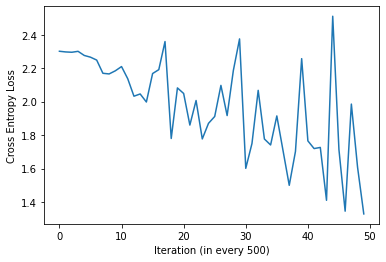

In [ ]:
plt.plot(Iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
save_model = True
model_save_name = 'experiment2.pt'
path = F"/content/gdrive/MyDrive/lab{model_save_name}" 

if save_model is True:
    # Saves only parameters
    # wights & biases
    #torch.save(model.state_dict(), root_path + 'linear_regression.pkl') 
    torch.save(model.state_dict(), path)